In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import LinearSVC
import re
import string
from sklearn.decomposition import TruncatedSVD

In [14]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

### Data Import and PreProcessing

In [15]:
pd_data_train = pd.read_csv('train.csv')

In [16]:
pd_data_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [17]:
pd_data_train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [18]:
location_values = pd_data_train['location'].value_counts()

In [19]:
keywords_values = pd_data_train['keyword'].value_counts()

In [20]:
# train_data = pd.get_dummies(pd_data_train, columns=['keyword'])
train_data = pd_data_train.drop(columns=['location','id', 'keyword'])
train_data = train_data.fillna(0)

In [21]:
train_data['text'] = train_data['text'].apply(lambda text: re.sub('[^\w]', ' ',text) )

In [22]:
Y = train_data['target'].to_numpy()
X = train_data.drop(columns=['target']).to_numpy()
x_text = X[:,0:1]

### TFIDF

In [23]:
tfidf = TfidfVectorizer(ngram_range=(1,4),max_features=15000)
x_preprocessed = []
for i in range(len(x_text)):
    tokens = x_text[i:i+1][0][0].split()
    tokens = [i.lower() for i in tokens]
    tokens = [i for i in tokens if i not in stop_words]
    tokens = [i.translate(str.maketrans('', '', string.punctuation)) for i in tokens]
    tokens = [re.sub("\s+", " ", i) for i in tokens]
    x_preprocessed.append(" ".join(tokens))
x_tf = tfidf.fit_transform(x_preprocessed).toarray()
x = np.concatenate((x_tf, X[:,1:]), axis=1)


In [24]:
tsvd = TruncatedSVD(n_components=2000)
tsvd.fit(x)
x_reduced = tsvd.transform(x)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_reduced, Y, test_size=0.25, random_state=21)
y_train = y_train.flatten()

Linear SVM Accuracy: 80.25210084033614 %


d:\kaggle_competitions\nlp-getting-started\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


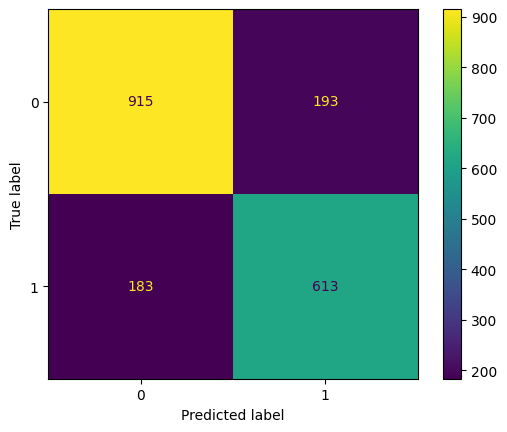

In [26]:
model = LinearSVC(class_weight='balanced', C=0.1)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
errors = np.sum(predictions != y_test.flatten())
print(f'Linear SVM Accuracy: {(1 - errors / len(x_test)) * 100} %')
lsvm_cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(model, x_test, y_test)

In [ ]:
test_data = pd.read_csv('test.csv')
# test_data = pd.get_dummies(test_data, columns=['keyword'])
test_data.drop(columns=['location','keyword'], inplace=True)
test_data['text'].apply(lambda text: re.sub('[^\w]', ' ',text))

x_sub = test_data['text'].to_numpy()
x_sub_processed = []
for i in range(len(x_sub)):
    toks = x_sub[i:i+1][0].split()
    toks = [i.lower() for i in toks]
    toks = [ i for i in toks if i not in stop_words]
    toks = [i.translate(str.maketrans('', '', string.punctuation)) for i in toks]
    toks = [re.sub("\s+", " ", i) for i in toks]
    x_sub_processed.append(" ".join(toks))

x_sub_tf = tfidf.transform(x_sub_processed).toarray()
x_sub_tf = np.concatenate((x_sub_tf, test_data.drop(columns=['text', 'id']).to_numpy()), axis=1)
x_sub_final = tsvd.fit_transform(x_sub_tf)
sub_preds = model.predict(x_sub_final)
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['target'] = sub_preds

In [ ]:
submission.to_csv('svm_1.csv', index=False)